##5.3 전이학습
- 일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함
  - 이를 해결하기 위해 전이 학습을 사용
- 전이 학습: 이미지넷처럼 아주 큰 데이터셋을 사용하여 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것
  - 아주 큰 데이터 셋으로 훈련된 모델: 사전 훈련 모델(네트워크)
  - 비교적 적은 수의 데이터를 가지고도 과제를 해결 가능해짐
- 전이 학습은 **특성 추출**과 **미세 조정 기법** 2가지로 분류됨

###5.3.1 특성 추출 기법
- ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결츨 부분만 새로 만드는 것
- 학습할 때는 마지막 완전 연결층만 학습하고 나머지 계층들은 학습되지 않도록 함
- 이미지 분류를 위해 2 부분으로 구성됨
  - 합성곱층: 합성곱층과 풀링층으로 구성
  - 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

-> 즉, 사전 훈련된 네트워크의 합성곱층에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킴

[1] 라이브러리 호출

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

[2] 이미지 데이터 전처리 방법 정의

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms

class FilenameLabelDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

        self.labels = [f.split('.')[0] for f in self.img_files]

        self.classes = sorted(list(set(self.labels)))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        self.numeric_labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.numeric_labels[idx]

        return image, label

data_path = "/content/drive/MyDrive/Colab Notebooks/data/train"

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = FilenameLabelDataset(
    img_dir=data_path,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print("전체 이미지 개수:", len(train_dataset))
print("클래스 목록:", train_dataset.classes)
print("클래스 → 숫자 매핑:", train_dataset.class_to_idx)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
전체 이미지 개수: 25048
클래스 목록: ['cat', 'dog']
클래스 → 숫자 매핑: {'cat': 0, 'dog': 1}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


- resize: 이미지 크기를 조정해줌
  - 합성곱층을 통과하기 위해 이미지 크기를 조절하는 전처리 과정
- randomResizedCrop:이미지를 랜덤한 크기 및 비율로 자름
  - 데이터의 확장용도로 사용
- RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음
- ToTensor: 텐서로 변환

[3] 학습에 사용될 이미지 출력

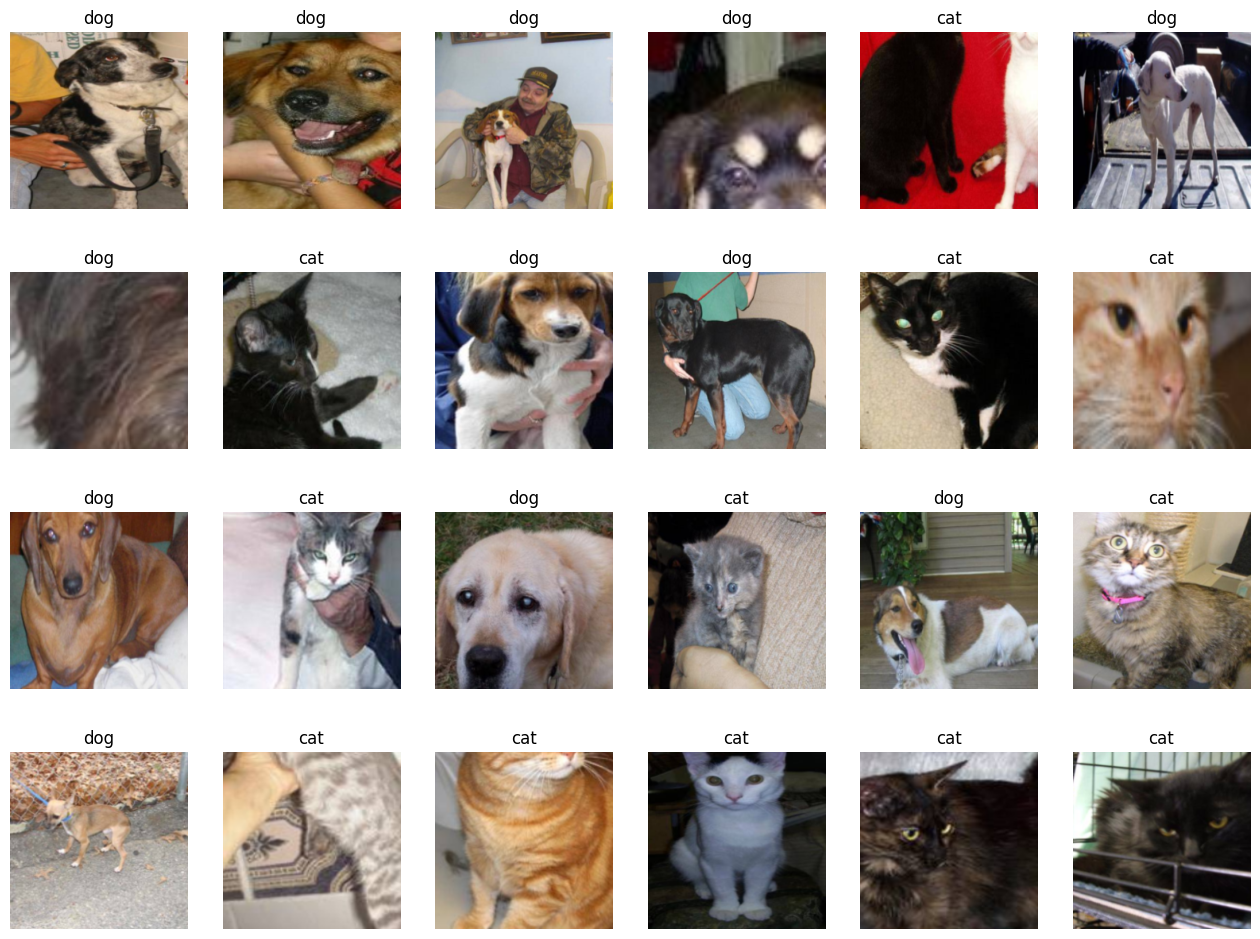

In [5]:
import numpy as np

samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

- 반복자를 사용하기 위해선 iter(), next()가 필요
  - iter(): 데이터 반복자를 꺼내 반환
  - next(): 반복자가 다음에 출력해야하는 요소를 반환
- np.transpos(): 행과 열을 변환하여 행렬의 차원을 바꾸어줌

[4] 사전 훈련된 모델 내려받기

In [6]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


- pretrained=True: 사전 학습된 가중치를 사용
- ResNet18: 50개의 계층으로 구성된 합성곱 신경망

[5] 사전 훈련된 모델의 파라미터 학습 유무 지정

In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

- 역전파 중 파라미터 들에 대한 변화를 계산할 필요가 없음 -> requires_grad = False로 설정
- ResNet18 마지막 부분에 완전 연결층을 추가함 -> 개와 고양이의 클래스를 분류하는 용도로 사용

[6] Resnet18에 완전연결층 추가

In [8]:
resnet18.fc = nn.Linear(512, 2)

[7] 모델의 파라미터 값 확인

In [9]:
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0055, -0.0002,  0.0156,  ...,  0.0208, -0.0415, -0.0167],
        [ 0.0304, -0.0408, -0.0295,  ..., -0.0034, -0.0357, -0.0283]])
fc.bias tensor([ 0.0165, -0.0398])


[8] 모델 객체 생성 및 손실 함수 정의

In [11]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

[9] 모델 학습을 위한 함수 생성

In [21]:
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=13):
    import time
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        save_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/', '{:02d}.pth'.format(epoch))
        torch.save(model.state_dict(), save_path)

        print()

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history, loss_history


[10] 파라미터 학습 결과를 옵티마이저에 전달

In [22]:
params_to_update=[]
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("/t", name)

optimizer = optim.Adam(params_to_update)

/t fc.weight
/t fc.bias


[11] 모델 학습

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.1680 Acc: 0.9270

Epoch 1/12
----------
Loss: 0.1565 Acc: 0.9320

Epoch 2/12
----------
Loss: 0.1547 Acc: 0.9323

Epoch 3/12
----------
Loss: 0.1519 Acc: 0.9333

Epoch 4/12
----------
Loss: 0.1522 Acc: 0.9352

Epoch 5/12
----------
Loss: 0.1532 Acc: 0.9338

Epoch 6/12
----------
Loss: 0.1463 Acc: 0.9384

Epoch 7/12
----------
Loss: 0.1494 Acc: 0.9342

Epoch 8/12
----------
Loss: 0.1585 Acc: 0.9307

Epoch 9/12
----------
Loss: 0.1478 Acc: 0.9355

Epoch 10/12
----------
Loss: 0.1480 Acc: 0.9356

Epoch 11/12
----------
Loss: 0.1521 Acc: 0.9353

Epoch 12/12
----------
Loss: 0.1471 Acc: 0.9372

Training complete in 35m 1s
Best Acc: 0.9384


[12] 테스트 데이터 호출 및 전처리

In [24]:
from google.colab import drive
drive.mount('/content/drive')

import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

# Custom Dataset
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name  # 이미지 tensor와 파일 이름 반환

# Transform
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Dataset
test_path = '/content/drive/MyDrive/Colab Notebooks/data/test1'
test_dataset = TestImageDataset(img_dir=test_path, transform=transform)

# DataLoader (collate_fn 사용해서 batch tensor로 변환)
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])  # batch tensor
    img_names = [item[1] for item in batch]           # 이름 리스트
    return images, img_names

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=False,
    collate_fn=collate_fn
)

print("테스트 이미지 개수:", len(test_dataset))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
테스트 이미지 개수: 12500


[13] 테스트 데이터 평가 함수 생성

In [41]:
def eval_model_test(model, dataloader, device):
    import time, glob, os
    since = time.time()

    saved_models = glob.glob('/content/drive/MyDrive/Colab Notebooks/data/*.pth')
    saved_models.sort(key=lambda x: int(os.path.basename(x).split('.')[0]))
    print('saved_model:', saved_models)

    model = model.to(device)
    model.eval()

    all_model_preds = []

    for model_path in saved_models:
        print('Loading model', model_path)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        preds_list = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                preds_list.extend(preds.cpu().numpy())

        all_model_preds.append(preds_list)
        print(f'Model {os.path.basename(model_path)} done.')

    time_elapsed = time.time() - since
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return all_model_preds


[14] 테스트 데이터를 평가 함수에 적용

In [ ]:
val_acc_hist=eval_model_test(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/catanddog/00.pth', '/content/drive/MyDrive/catanddog/01.pth', '/content/drive/MyDrive/catanddog/02.pth', '/content/drive/MyDrive/catanddog/03.pth', '/content/drive/MyDrive/catanddog/04.pth', '/content/drive/MyDrive/catanddog/05.pth', '/content/drive/MyDrive/catanddog/06.pth', '/content/drive/MyDrive/catanddog/07.pth', '/content/drive/MyDrive/catanddog/08.pth', '/content/drive/MyDrive/catanddog/09.pth', '/content/drive/MyDrive/catanddog/10.pth', '/content/drive/MyDrive/catanddog/11.pth', '/content/drive/MyDrive/catanddog/12.pth']
Loading model /content/drive/MyDrive/catanddog/00.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/catanddog/01.pth
Acc: 0.9592

Loading model /content/drive/MyDrive/catanddog/02.pth
Acc: 0.9592

Loading model /content/drive/MyDrive/catanddog/03.pth
Acc: 0.9184

Loading model /content/drive/MyDrive/catanddog/04.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/catanddog/05.pth
Acc: 0.9388

Loading model /content/dri

[15] 훈련과 테스트 데이터의 정확도를 그래프로 확인

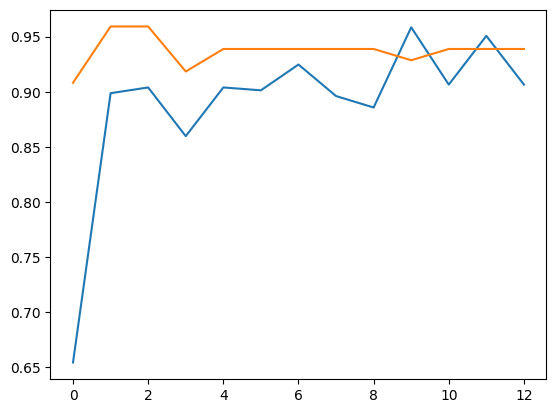

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

[16] 훈련 데이터의 오차에 대한 그래프 확인

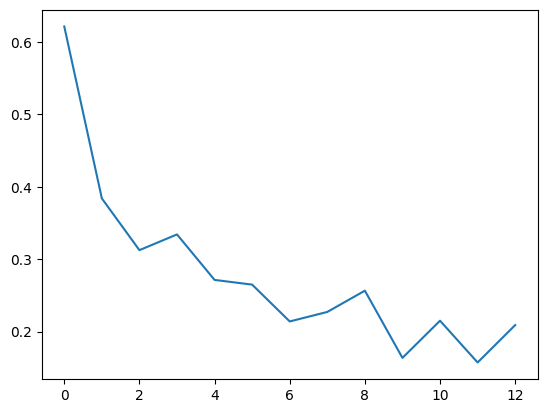

In [ ]:
plt.plot(train_loss_hist)
plt.show()

[17] 예측 이미지 출력을 위한 전처리 함수

In [ ]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1, 2, 0)
    image=image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image=image.clip(0, 1)
    return image

- tensor.clone: 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미
  - detach: 기존 텐서에서 기울기가 전파되지 않는 텐서

[18] 개와 고양이 예측 결과 출력

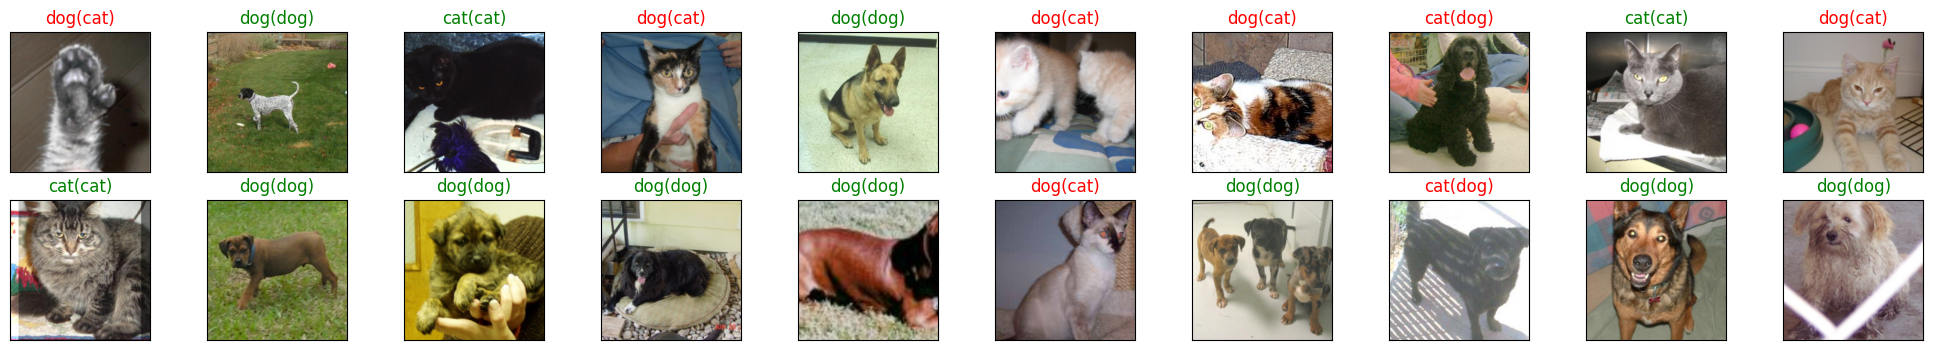

<Figure size 640x480 with 0 Axes>

In [ ]:
classes={0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images, labels=next(dataiter)
output=model(images)
_, preds=torch.max(output, 1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].
                                                                              item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

###5.3.2 미세 조정 기법
- 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
- 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습 시킴
  - 사전 훈련된 네트워크를 미세 조정하여 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정하는 기법
    - 많은 연산량이 필요하므로 GPU 사용 권장
- 미세 조정 기법 전략
  - 데이터셋이 크고 사전 훈련된 모델과 유사성이 작은 경우: 모델 전체를 재학습 시킴
  - 데이터셋이 크고 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분과 데이터 분류기를 학습시킴. 데이터셋이 유사하기 때문에 전체를 재학습 시키는 것보다 일부만 새로 학습시켜도 최적의 성능을 나타냄
  - 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분과 데이터 분류기를 학습시킴. 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용해도 효과가 없을 수 있어, 어느부분까지 새로 학습 시킬건지 범위를 지정해주어야 함
  - 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우: 데이터 분류기만 학습시킴. 데이터가 적어 많은 계층에 미세 조정 기법을 적용하면 과적합 발생 가능
- 자칫하면 과적합 문제가 발생할 수 있어 정교하고 미세한 파라미터 업데이트가 필요함
  